In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from nbs.evaluation import evaluate_model
from nbs.preprocessing import run_feature_engineering

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [3]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')
test_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [7]:
X_train, X_val, X_test = run_feature_engineering(X_train, X_val, X_test)

🚧 Starting feature engineering pipeline...

✅ Transaction amount ratios created
✅ Data cleaned
✅ Rare categories grouped
✅ Categorical columns encoded
✅ Train set processed
✅ Validation set processed
✅ Test set processed
✅ Unused columns dropped

🎯 Final Shapes:
📐 X_train shape: (377945, 430)
📐 X_val shape:   (94487, 430)
📐 X_test shape:  (118108, 430)
🔍 Columns in train but not in test: set()
🔍 Columns in test but not in train: set()


In [8]:
for name, X in zip(['Train', 'Validation', 'Test'], [X_train, X_val, X_test]):
    unique_dtypes = X.dtypes.unique()
    print(f"{name} unique dtypes: {list(unique_dtypes)}")

Train unique dtypes: [dtype('int64'), dtype('float64')]
Validation unique dtypes: [dtype('int64'), dtype('float64')]
Test unique dtypes: [dtype('int64'), dtype('float64')]


In [9]:
def evaluate_random_forest_estimators(X_train, y_train, X_val, y_val, estimator_range):
    scores = []

    for n in estimator_range:
        rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_val_pred_proba = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred_proba)
        scores.append(auc)
        print(f"n_estimators={n} => AUC: {auc:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(estimator_range, scores, marker='o')
    plt.title('Random Forest AUC vs. n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Validation AUC')
    plt.grid(True)
    plt.show()

    return scores


In [10]:
# def print_column_ranges(X_train, X_val, X_test):
#     print("Column Ranges:")
#     for col in X_train.columns:
#         min_val = min(X_train[col].min(), X_val[col].min(), X_test[col].min())
#         max_val = max(X_train[col].max(), X_val[col].max(), X_test[col].max())
#         print(f"{col}: Min = {min_val}, Max = {max_val}")

# # Call the function assuming X_train, X_val, X_test are defined
# print_column_ranges(X_train, X_val, X_test)

In [11]:
# estimator_range = range(10, 210, 20) 
# scores = evaluate_random_forest_estimators(X_train, y_train, X_val, y_val, estimator_range)

In [12]:
model = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)


Validation Metrics:
AUC: 0.9339
Accuracy: 0.9795
Precision: 0.9449
Recall: 0.4410
F1 Score: 0.6014
Log Loss: 0.0829
Brier Score: 0.0171
Average Precision: 0.7156

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91181
           1       0.94      0.44      0.60      3306

    accuracy                           0.98     94487
   macro avg       0.96      0.72      0.80     94487
weighted avg       0.98      0.98      0.98     94487

Confusion Matrix:
[[91096    85]
 [ 1848  1458]]

Test Metrics:
AUC: 0.9220
Accuracy: 0.9789
Precision: 0.9413
Recall: 0.4232
F1 Score: 0.5839
Log Loss: 0.0978
Brier Score: 0.0189
Average Precision: 0.7076

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.94      0.42      0.58      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.71     

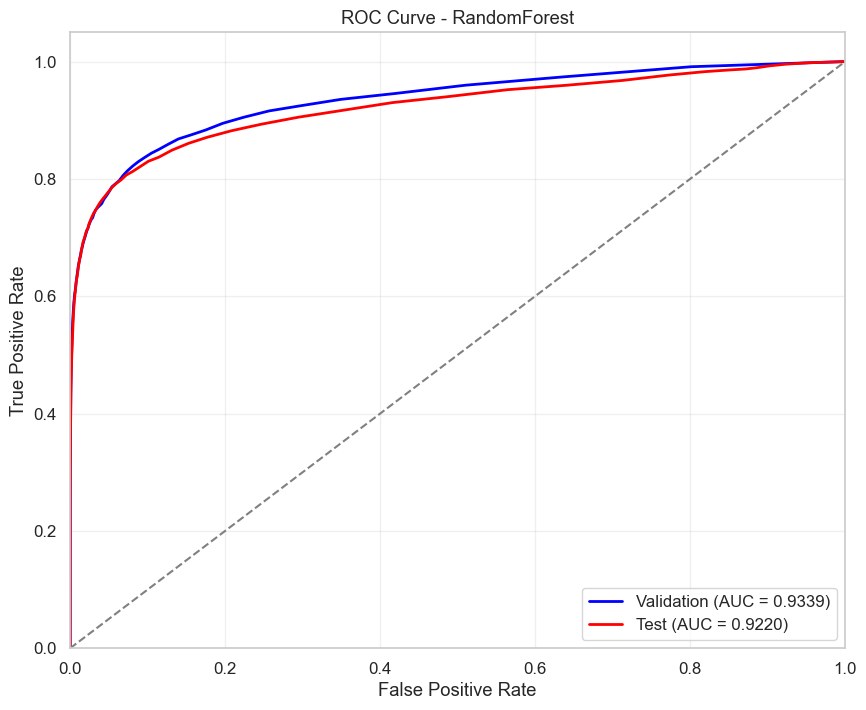

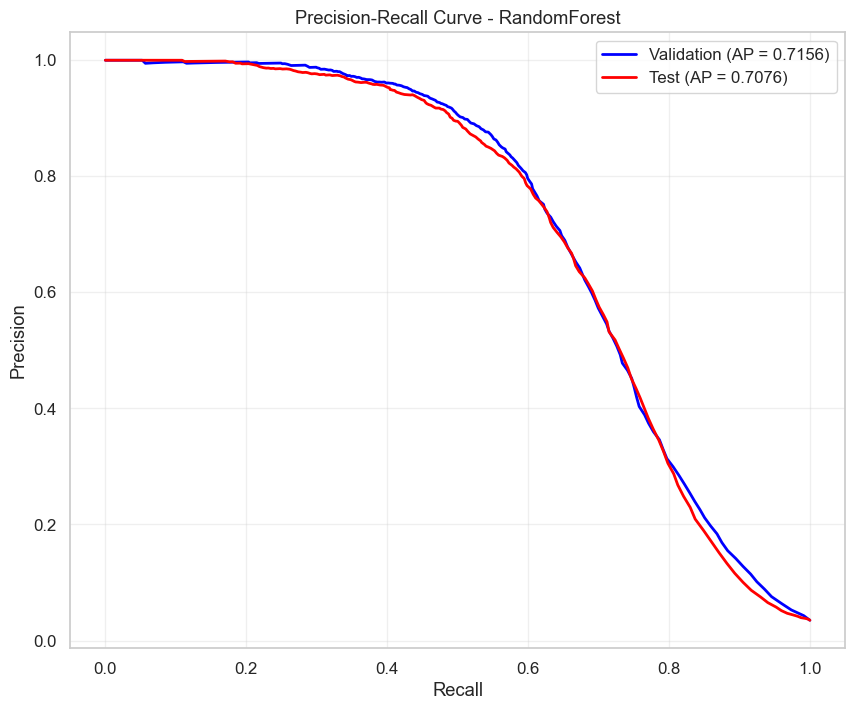

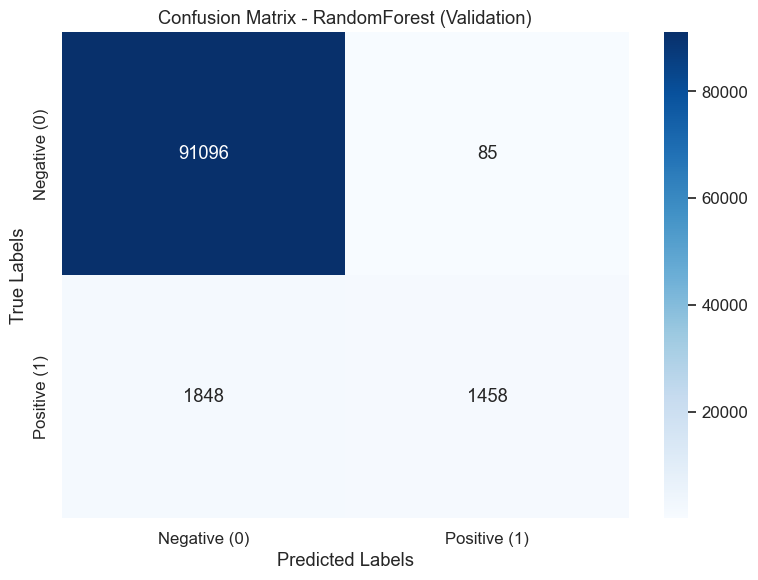

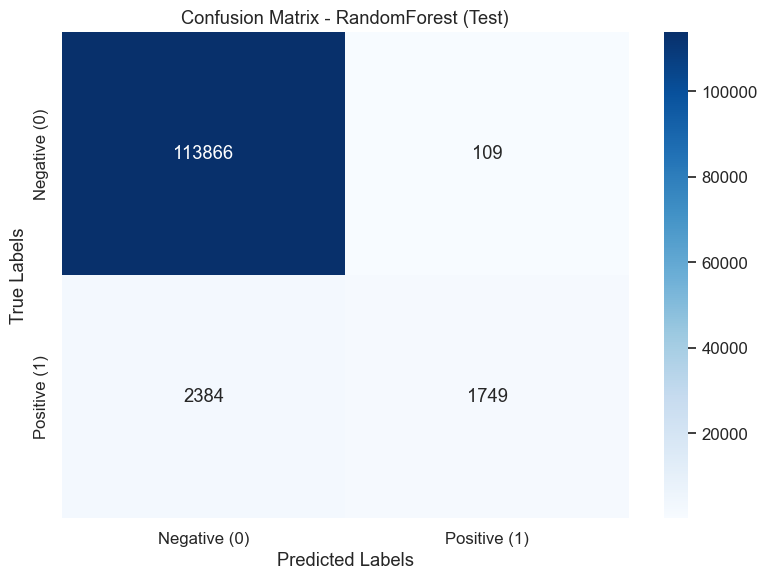

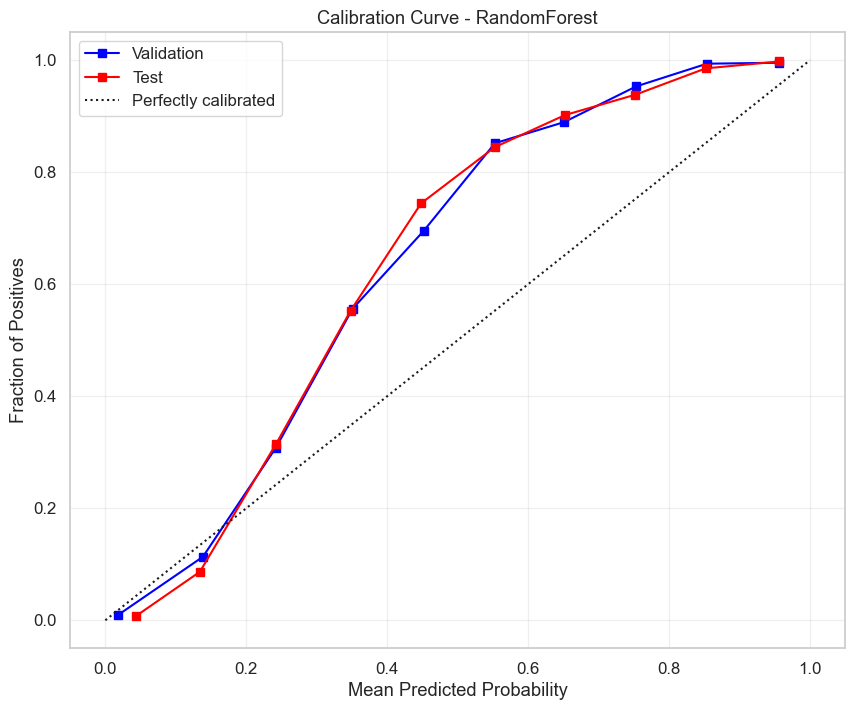

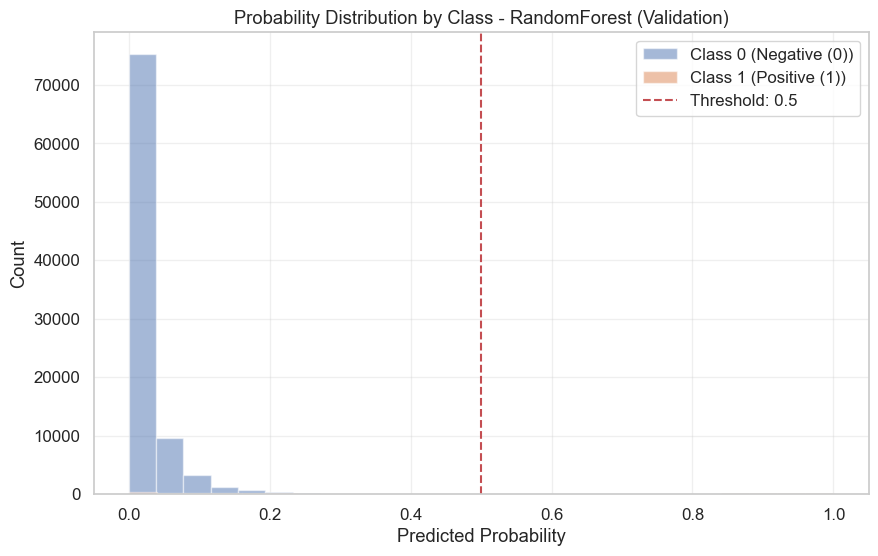

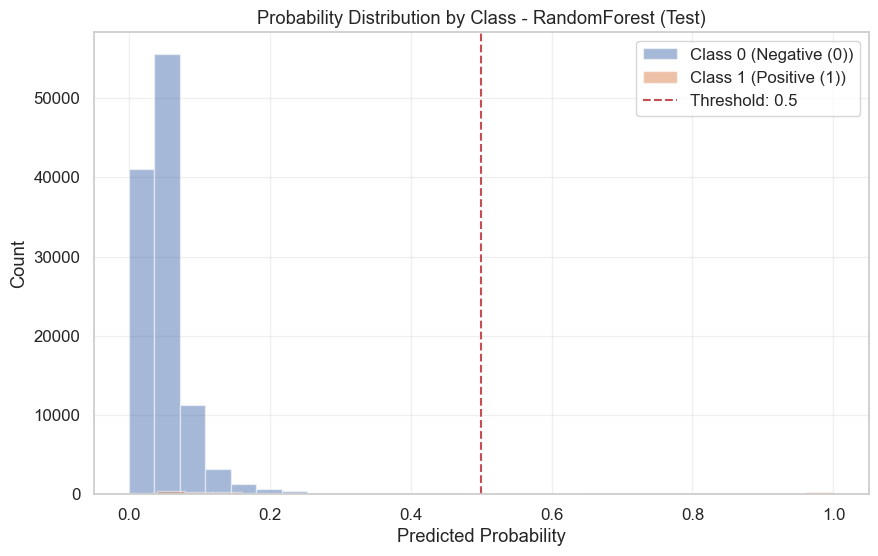

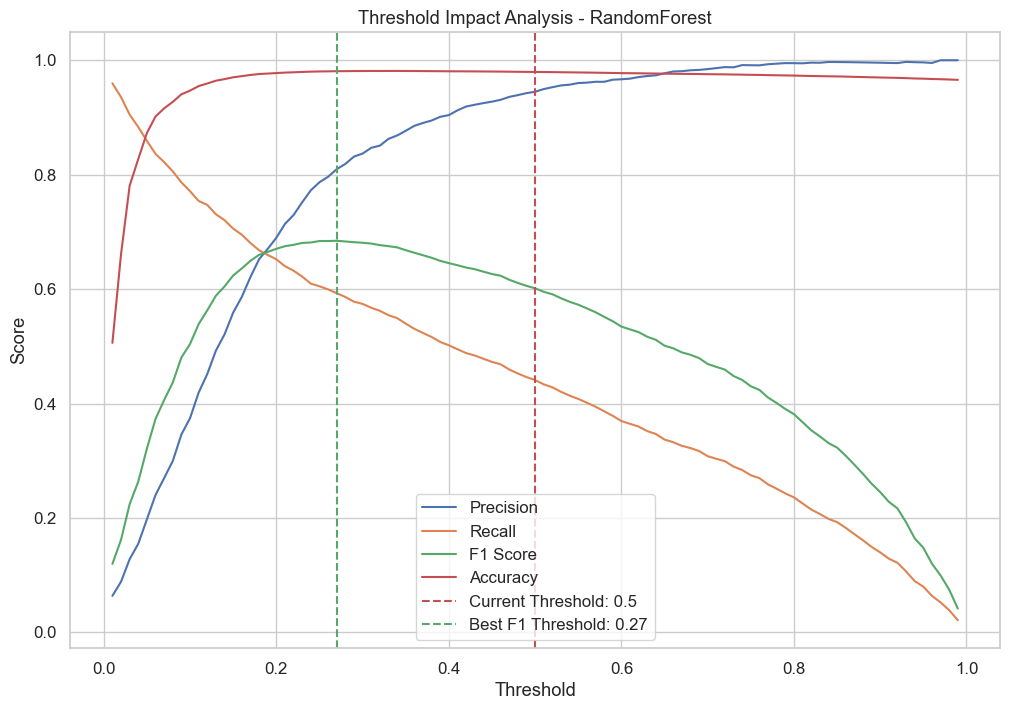

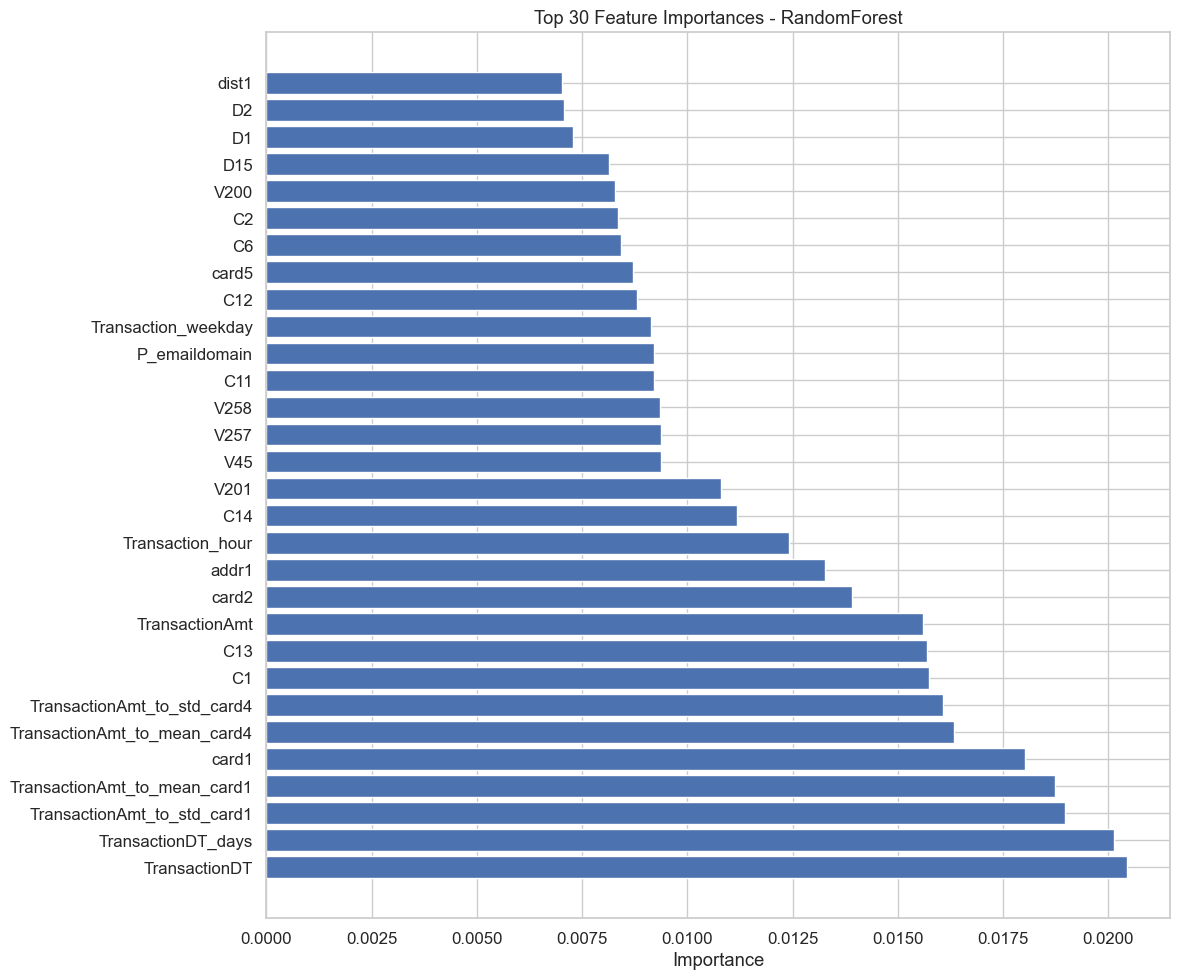

{'validation': {'auc': np.float64(0.9339460048859559),
  'accuracy': 0.9795421592388371,
  'precision': 0.9449125081011017,
  'recall': 0.44101633393829404,
  'f1': 0.601361105382553,
  'log_loss': 0.08287010529689141,
  'brier_score': np.float64(0.017111906103485137),
  'average_precision': np.float64(0.715562127208345),
  'confusion_matrix': array([[91096,    85],
         [ 1848,  1458]]),
  'classification_report': {'0': {'precision': 0.9801170597348942,
    'recall': 0.9990677882453581,
    'f1-score': 0.9895016972165648,
    'support': 91181.0},
   '1': {'precision': 0.9449125081011017,
    'recall': 0.44101633393829404,
    'f1-score': 0.601361105382553,
    'support': 3306.0},
   'accuracy': 0.9795421592388371,
   'macro avg': {'precision': 0.9625147839179979,
    'recall': 0.7200420610918261,
    'f1-score': 0.7954314012995589,
    'support': 94487.0},
   'weighted avg': {'precision': 0.9788852897802833,
    'recall': 0.9795421592388371,
    'f1-score': 0.9759210692296116,
   

In [13]:
evaluate_model(
    model,
    X_val,
    y_val,
    X_test,
    y_test,
    threshold=0.5,
    model_name="RandomForest",
    is_lightgbm=False
)